During some readings I found [this post](https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html) in KDnuggets about Long Short-Term Memory and how to use it for stock market prediction. So, I decided to write down a kernel with an example.

### What is (in general) Long Sort-Term Memory (LSTM) ###

LSTM is a type of recurrent neural network (RNN) that store past information to use it when predicting future values. Storing data is made by using hidden layers self connected, that ensure the consistant flow of information simulating a memory. 

One of the most interesting parts about RNN is how the manage the input and output information. As vanilla neural networks (and convolutional neural network) only manage fixed input and output vectors, the RNN can handle sequence of vectors for input, output or both.

For more in deep explaniation about it, you can refer to the following pages.
* [A Beginner’s Guide to Implementing Long Short-Term Memory Networks (LSTM).](https://heartbeat.fritz.ai/a-beginners-guide-to-implementing-long-short-term-memory-networks-lstm-eb7a2ff09a27)
* [Recurrent Neural Networks Tutorial, Part 1 – Introduction to RNNs](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/)
* [Recurrent Neural Networks for Beginners](https://medium.com/@camrongodbout/recurrent-neural-networks-for-beginners-7aca4e933b82)
* [An Introduction to Recurrent Neural Networks](https://medium.com/explore-artificial-intelligence/an-introduction-to-recurrent-neural-networks-72c97bf0912)

Now, knowing the basics of what is a recurrent neural network it's time to procced with the example. We're going to use a data set of historical prices of most popular cryptocoins. 

First, we'll load numpy and pandas library to read the data. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

df_price = pd.read_csv("../input/CryptocoinsHistoricalPrices.csv",
                      names = ['No','Date','Open','High','Low','Close','Volume','Market_Cap','Coin','Open_Cero','Close_Cero','Delta'],
                      index_col = ['Date'], 
                      parse_dates = ['Date'],
                      usecols = [0, 1, 2, 3, 4, 5, 8, 11],
                      na_filter = True)
df_price.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,3,4,5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,No,Open,High,Low,Close,Coin,Delta
Date,,,,,,,
Date,NaN,Open.,High,Low,Close..,coin,Delta
2018-08-14,1.0,6287.66,6287.94,5971.05,6199.71,BTC,-0.0139877156207555
2018-08-13,2.0,6341.36,6537.05,6225.72,6297.57,BTC,-0.00690545876594295
2018-08-12,3.0,6283.65,6409.85,6237.5,6322.69,BTC,0.00621294947999968
2018-08-11,4.0,6185.79,6455.74,6109.03,6295.73,BTC,0.0177729926169494


In [2]:
# Looking at first row, it has the names of columns but we already have them, so we'll remove it.
df_price = df_price[1:]

In [3]:
# Some values are still non numeric, we can see it by looking at their type
print('Open column type', type(df_price.Open[0]))
print('Close column type', type(df_price.Close[0]))

Open column type <class 'str'>
Close column type <class 'str'>


In [4]:
# But, why they are still str and not numeric? Let's try to convert it into numeric as it
try:
    df_price.Open = pd.to_numeric(df_price.Open)
except Exception as e:
    print(e)
# Check for Nan    
df_price = df_price.reset_index()
print("Nan values: \n",df_price.isnull().sum())

Unable to parse string "105,072" at position 496011
Nan values: 
 Date       4
No         0
Open       0
High     731
Low      646
Close      0
Coin       0
Delta    717
dtype: int64


Apparently there are still characters that can be interpretated as part of a numeric value. For that reason a convertion is needed, to do that, Andy user in stackoverflow presents a pretty good approach to perform it. The full answer and explanation can be found in this [link](https://stackoverflow.com/questions/51287850/how-to-find-special-characters-from-python-data-frame).
As we can see in the exception message, a value has a comma at position 496009 and because of that value, we're unable to parse all values in column. Also, there are columns having Nan values and one of them is Date column. Let's clean this up by removing all Nan values for Date.

In [5]:
# Once we clean de data set, let's try again to convert Open and Close columns to numeric
df_price.dropna(inplace=True)
print(df_price.isnull().sum())
# Converting the data, we found there are no more error while parsing. So, move on!
print("Open parsing errors",pd.to_numeric(df_price.Open, errors='occurrs').isnull().sum())
print("Close parsing errors",pd.to_numeric(df_price.Close, errors='occurrs').isnull().sum())
df_price.Open = pd.to_numeric(df_price.Open)
df_price.Close = pd.to_numeric(df_price.Close)

Date     0
No       0
Open     0
High     0
Low      0
Close    0
Coin     0
Delta    0
dtype: int64
Open parsing errors 0
Close parsing errors 0


In [6]:
# Because we removed the index when we'd found Nan, we must set the index again.
ts = df_price.set_index(df_price.Date)

In [7]:
# Once all data is cleared, it's time to create time series of each cryptocurrencies of interes.
# We'll use BTC
ts_BTC = ts[ts.Coin == 'BTC'].Open.copy()
#ts_ETC = ts[ts.Coin == 'ETC'].Open.copy()
#ts_LTC = ts[ts.Coin == 'LTC'].Open.copy()
#ts_XRP = ts[ts.Coin == 'XRP'].Open.copy()

In [8]:
# Now, let's plot time series with plotly to make it interactive
import plotly.graph_objs as go
from plotly import tools
# Offline mode
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
# Prepare data
btc_data = go.Scatter(x=ts_BTC.index, y=ts_BTC.values)
#etc_data = go.Scatter(x=ts_ETC.index, y=ts_ETC.values)
#ltc_data = go.Scatter(x=ts_LTC.index, y=ts_LTC.values)
#xrp_data = go.Scatter(x=ts_XRP.index, y=ts_XRP.values)
# Create figure
#fig = tools.make_subplots(rows=2, cols=2,
#                          subplot_titles=('BTC Time Serie', 'ETC Time Serie',
#                                                         'LTC Time Serie', 'XRP Time Serie'))
# Append data
#fig.append_trace(btc_data, 1, 1)
#fig.append_trace(etc_data, 1, 2)
#fig.append_trace(ltc_data, 2, 1)
#fig.append_trace(xrp_data, 2, 2)
# Prepare layout
#fig['layout'].update(height=600, width=800, showlegend = False, title='Cryptocurrencies time series')
data_plot = [btc_data]
# Plot figure
iplot(data_plot)

Derrick Mwiti in his writting on KDnuggets suggest to scal the data when working with deep learning models for better performance. Scikit-Learn offers solutions to this problem. We're going to follow the example of Derrick and scale it with *MinMaxScaler* and scale between 0 and 1, but remember that exists other alternatives of transformations like logarithmic transformation. Furthermore, the training will be compounded by 60 examples.

In [9]:
btc_data_1 = go.Scatter(x=ts_BTC.iloc[60:].index, y=ts_BTC.values)
btc_data_2 = go.Scatter(x=ts_BTC.iloc[:60].index, y=ts_BTC.values)
data_plot = [btc_data_1, btc_data_2]
# Plot figure
iplot(data_plot)

In [10]:
from sklearn.preprocessing import MinMaxScaler
from pandas import Timestamp
# Set range
sc = MinMaxScaler(feature_range = (0,1))
# Reset index to be able to manipulate index
btc_data2scal = ts_BTC.iloc[60:].reset_index()
# Convert date into float timestamp
btc_data2scal.Date = btc_data2scal.Date.apply(pd.to_datetime).apply(Timestamp.timestamp)
# Scal the data
ts_BTC_scaled = sc.fit_transform(btc_data2scal.values)
# Create 3D train matrix and output matrix for training
X_train = np.array([ts_BTC_scaled[v-60:v, 0] for v in range(60, btc_data2scal.shape[0])])
Y_train = np.array([ts_BTC_scaled[v, 0] for v in range(60, btc_data2scal.shape[0])])
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

Once data is prepared, we can build our LTSM model using keras. Again, we're following what Derrick tells on his post:

> 1. 50 units which is the dimensionality of the output space
> 2. return_sequences=True which determines whether to return the last output in the output sequence, or the full sequence
> 3. input_shape as the shape of our training set.

Derrick suggets make use of Dropout techinique but I was wondering 

### What is dropout and why is used? ###
 According to Wikipedia
> The term “dropout” refers to dropping out units (both hidden and visible) in a neural network.

That is, when a neural network is learning we specifiy the percentage of units that will be dropped at random. Dropout is used because it abvoids the overfitting by removing the co-dependency.

To review more technical details, refere to this text [Dropout in (Deep) Machine learning](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5).

In [11]:
# Import keras modules to build model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, Y_train, epochs = 100, batch_size = 32)

Using TensorFlow backend.


Epoch 1/100
1815/1815 [==============================] - 29s 16ms/step - loss: 0.0413
Epoch 2/100
1815/1815 [==============================] - 25s 14ms/step - loss: 0.0035
Epoch 3/100
1815/1815 [==============================] - 25s 14ms/step - loss: 0.0028
Epoch 4/100
1815/1815 [==============================] - 26s 14ms/step - loss: 0.0027
Epoch 5/100
1815/1815 [==============================] - 26s 14ms/step - loss: 0.0026
Epoch 6/100
1815/1815 [==============================] - 26s 14ms/step - loss: 0.0026
Epoch 7/100
1815/1815 [==============================] - 25s 14ms/step - loss: 0.0025
Epoch 8/100
1815/1815 [==============================] - 26s 14ms/step - loss: 0.0024
Epoch 9/100
1815/1815 [==============================] - 26s 14ms/step - loss: 0.0023
Epoch 10/100
1815/1815 [==============================] - 26s 14ms/step - loss: 0.0020
Epoch 11/100
1815/1815 [==============================] - 26s 14ms/step - loss: 0.0021
Epoch 12/100
1815/1815 [============================

1815/1815 [==============================] - 27s 15ms/step - loss: 7.2444e-04
Epoch 94/100
1815/1815 [==============================] - 27s 15ms/step - loss: 6.5045e-04
Epoch 95/100
1815/1815 [==============================] - 25s 14ms/step - loss: 7.1672e-04
Epoch 96/100
1815/1815 [==============================] - 25s 14ms/step - loss: 6.7350e-04
Epoch 97/100
1815/1815 [==============================] - 25s 14ms/step - loss: 5.2686e-04
Epoch 98/100
1815/1815 [==============================] - 25s 14ms/step - loss: 5.9451e-04
Epoch 99/100
1815/1815 [==============================] - 25s 14ms/step - loss: 6.1443e-04
Epoch 100/100
1815/1815 [==============================] - 26s 14ms/step - loss: 5.8703e-04


In [55]:
btc_sp_test = ts_BTC.iloc[:60]
btc_sp_train = ts_BTC.iloc[60:]

btc_sp_test = btc_sp_test.reset_index()
btc_sp_train = btc_sp_train.reset_index()

dataset_total = pd.concat((btc_sp_train.Open, btc_sp_train.Open), axis = 0)
inputs = dataset_total[len(dataset_total) - len(btc_sp_test) - 60:].values
inputs = inputs.reshape(-1,2)
inputs = sc.transform(inputs)
inputs = inputs.reshape(-1,1)
X_test = [inputs[i-60:i, 0] for i in range(60, 76)]
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(-1,2)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

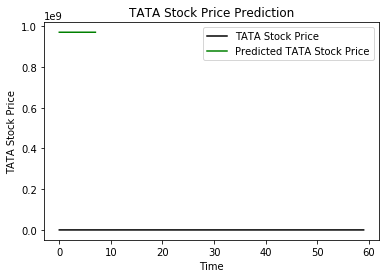

In [62]:
import matplotlib.pyplot as plt
#btc_sp_test = btc_sp_test.reset_index()
plt.plot(btc_sp_test.Open, color = 'black', label = 'TATA Stock Price')
plt.plot(predicted_stock_price[...,0], color = 'green', label = 'Predicted TATA Stock Price')
plt.title('TATA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()